In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os
from shutil import copyfile

# get_deployment
This jupyter notebook uses a Cyclus simulation output with only the legacy U.S. fleet and calculates the deployment scheme for a given reactor design and power demand. This process takes three steps:
1. Get current power capacity vs time
2. Deploy lwrs until new reactor designs become available
3. Deploy advanced reactors to meet power demand

In [4]:
import write_input.demand_deploy as dd
import analysis as an

In [5]:
# sqlite file with only the legacy lwrs from 2013/05
cur = an.get_cursor('./legacy_only.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)
power_dict = an.get_power_dict(cur)
for key, val in power_dict.items():
    # start from 2020 -> 6 years and 7 months (80 months later)
    power_dict[key] = val[80:]

OperationalError: no such table: info

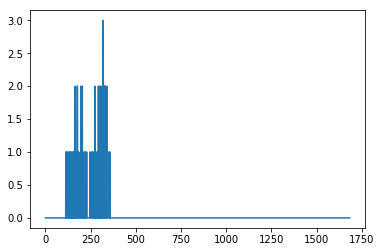

In [92]:
lwr_deploy_array, lwr_deployed_power = dd.get_new_deployment(power_dict, ['us_government'],
                                                     '100', 1.11, 960, 360, False)
power_dict['lwr'] = lwr_deployed_power
plt.plot(lwr_deploy_array)

In [93]:
# push back deploy times by five
lwr_deploy_array = np.append(np.array([0]*80), lwr_deploy_array[:-80])

In [94]:
dd.write_deployinst(lwr_deploy_array, 'lwr', 'lwr_dep.xml', 960)

## With LWRs deployed, the power looks like:

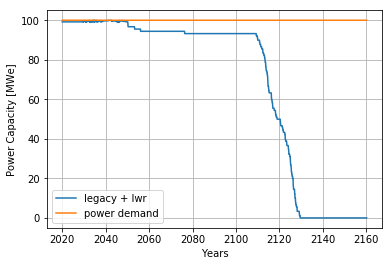

In [95]:
x = np.arange(0, 1684)
years = 2020 + x/12
y = 100*(1.000)**(x/12)
plt.plot(years, power_dict['us_government'] + power_dict['lwr'], label='legacy + lwr')
plt.plot(years, y, label='power demand')
plt.xlabel('Years')
plt.ylabel('Power Capacity [MWe]')
plt.legend()
plt.grid()

## To fill in the lack from 2020, deploy MSRs:

95.0

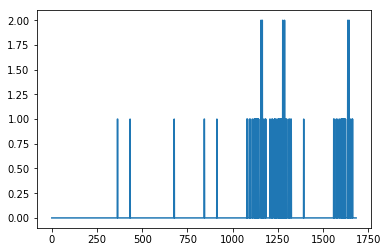

In [99]:
# rebus
msr_power = 3.7*0.44
lifetime = 40*12
msr_deploy_array, msr_deployed_power = dd.get_new_deployment(power_dict, ['us_government', 'lwr'],
                                                     '100*(1.000)**(t/12)', msr_power, lifetime, 360, True)
power_dict['msr'] = msr_deployed_power
plt.plot(msr_deploy_array)
sum(msr_deploy_array)

In [100]:
# push back deploy times by five
tail = msr_deploy_array[:-80]
msr_deploy_array = np.append(np.array([0]*80), msr_deploy_array)

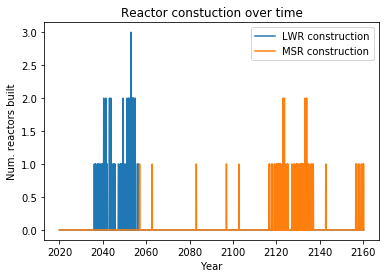

In [101]:
plt.plot(years, lwr_deploy_array, label='LWR construction')
plt.plot(years, msr_deploy_array[:-80], label='MSR construction')
plt.xlabel('Year')
plt.ylabel('Num. reactors built')
plt.legend()
plt.title('Reactor constuction over time')
plt.savefig('us_dep.png', format='png')
plt.show()

In [102]:
dd.write_deployinst(msr_deploy_array, 'rebus', 'rebus_dep_fourty.xml', 480)

## Now the total deployed power is:

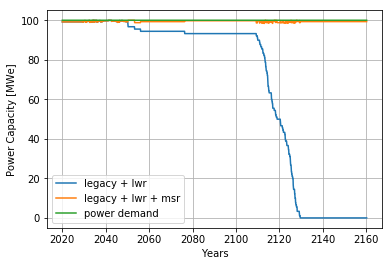

In [31]:
x = np.arange(0, 1684)
years = 2020 + x/12
y = 100*(1.000)**(x/12)
plt.plot(years, power_dict['us_government'] + power_dict['lwr'], label='legacy + lwr')
plt.plot(years, power_dict['us_government'] + power_dict['lwr'] + power_dict['msr'], label='legacy + lwr + msr')
plt.plot(years, y, label='power demand')
plt.xlabel('Years')
plt.ylabel('Power Capacity [MWe]')
plt.legend()
plt.grid()